# Train classification models for misinformation detection

## Initialize

In [2]:
######################################################
# Import libraries
######################################################

import pandas as pd
import numpy as np
import regex as re
from collections import Counter
from datetime import date
from tqdm import tqdm
import emoji

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stemmer = WordNetLemmatizer()

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import joblib
import csv

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import glob

[nltk_data] Downloading package punkt to /home/app59/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/app59/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/app59/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load & inspect data

### Define filepaths

In [3]:
thisday = date.today().strftime("%m%d%y")

# Multiple labeled data files for each myth
fvg_fps = [fp for fp in glob.glob('../data/samples/5G/*') if
           (fp.endswith('labeled.csv'))
          ]
neg_fvg_fps = [fp for fp in glob.glob('../data/samples/5G/negative_cases/*') if
           (fp.endswith('labeled.csv'))
          ]

msq_fps = [fp for fp in glob.glob('../data/samples/mosquitoes/*') if
           (fp.endswith('labeled.csv'))
          ]
neg_msq_fps = [fp for fp in glob.glob('../data/samples/5G/negative_cases/*') if
           (fp.endswith('labeled.csv'))
          ]

fvg_vec_fp = f'../models/vectorizer_5G_{str(thisday)}.joblib'
msq_vec_fp = f'../models/vectorizer_mosquitoes_{str(thisday)}.joblib'

### Load & rename data

In [4]:
# For multiple files holding labeled data, load each one and add to empty DF

# Mosquitoes
msq_df = pd.DataFrame() # initialize
for fp in msq_fps:
    temp = pd.read_csv(fp, low_memory=False) # read file
    msq_df = pd.concat([msq_df, temp]) # add positive tweets to main DF
#add negative tweets
for fp in neg_fvg_fps: 
    temp = pd.read_csv(fp, low_memory=False) # read file
    temp = temp[temp.myth_score == 1.0] # keep only negative tweets with score of 1.0 for other myth
    temp = temp.assign(myth_score = 0, myth_supports_score = 0) # change myth scores to zero
    temp = temp.assign(is_myth = "no", is_myth_supports = "no") # change myth labels to "no"
    msq_df = pd.concat([msq_df, temp]) # add negative tweets to main df
    
# 5G
fvg_df = pd.DataFrame() # initialize
for fp in fvg_fps:
    temp = pd.read_csv(fp, low_memory=False) # read file
    fvg_df = pd.concat([fvg_df, temp]) # add positive tweets to main DF
#add negative tweets
for fp in neg_fvg_fps: 
    temp = pd.read_csv(fp, low_memory=False) # read file
    temp = temp[temp.myth_score == 1.0] # keep only negative tweets with score of 1.0 for other myth
    temp = temp.assign(myth_score = 0, myth_supports_score = 0) # change myth scores to zero
    temp = temp.assign(is_myth = "no", is_myth_supports = "no") # change myth labels to "no"
    fvg_df = pd.concat([fvg_df, temp]) # add negative tweets to main df

    
# Rename each DF's myth columns for clarity
msq_df = msq_df.reset_index(drop=True).rename(
    copy = False, columns = 
    {'is_myth': 'msq_is_myth', 'myth_score': 'msq_myth_score', 
     'is_myth_supports': 'msq_is_myth_supports', 'myth_supports_score': 'msq_myth_supports_score'})

fvg_df = fvg_df.reset_index(drop=True).rename(
    copy = False, columns = 
    {'is_myth': 'fvg_is_myth', 'myth_score': 'fvg_myth_score', 
     'is_myth_supports': 'fvg_is_myth_supports', 'myth_supports_score': 'fvg_myth_supports_score'})

msq_df.tail(10)

,tweet_id,text,msq_is_myth,msq_myth_score,msq_is_myth_supports,msq_myth_supports_score
1238,1.256274e+18,@USER01 @USER02 #Covid19 was created in a Cana...,no,0.0,no,0.0
1239,1.270119e+18,The #Covid scare was an engineered hoax. Someo...,no,0.0,no,0.0
1240,1.279824e+18,Sir Richard Dearlove stressed the fact that th...,no,0.0,no,0.0
1241,1.237855e+18,"@USER01 Except, this time they have the engine...",no,0.0,no,0.0
1242,1.281818e+18,@USER01 @USER02 :confused_face::thinking_face:...,no,0.0,no,0.0
1243,1.236012e+18,Former IDF inteligence officer and expert on b...,no,0.0,no,0.0
1244,1.252298e+18,<em>URL01 Removed</em> Bioweapon 911- looking ...,no,0.0,no,0.0
1245,1.250571e+18,@USER01 @USER02 Gates &amp; Fauci are behind t...,no,0.0,no,0.0
1246,1.246429e+18,Weapon's Name: Human Spit Bio Gun \nWeapon cla...,no,0.0,no,0.0
1247,1.251635e+18,Did China Just Admit the Obama Administration ...,no,0.0,no,0.0


### Summarize the numerical data

In [5]:
# Look at the number of instances of each is_myth class distribution
print(msq_df.groupby('msq_is_myth').size())
print()
print(fvg_df.groupby('fvg_is_myth').size())
print()

# Look at the number of instances of each is_myth_supports class distribution
print(msq_df.groupby('msq_is_myth_supports').size())
print()
print(fvg_df.groupby('fvg_is_myth_supports').size())
print()

msq_is_myth
no        678
unsure      7
yes       563
dtype: int64

fvg_is_myth
no        526
unsure     11
yes       587
dtype: int64

msq_is_myth_supports
no        930
unsure    254
yes        64
dtype: int64

fvg_is_myth_supports
no        861
unsure    133
yes       130
dtype: int64



## Preprocess tweet text

### Tweet Preprocessing

In [6]:
def process_tweets(tweet):
    '''
    Preprocesses raw text of a tweet, skipping any retweets. 
    Steps: lower-casing; removing punctuation, newlines, URLs, usernames, and emojis;
    stripping whitespace, replacing hashtags, and finally, lemmatization.
    
    args:
        tweet: raw text of a tweet
    
    returns:
        string: cleaned tweet text
    '''
    
    # Skip retweets and non-strings
    retweet_pattern = r'^RT\s+' # recognize retweets by starting with 'RT'
    if not isinstance(tweet, str) or re.search(retweet_pattern, tweet):
        return ''
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove punctuation with regex: match all punctuation (\p{P}) and symbols (\p{S}), 
    # then check that it is not a wasn't a hashtag or @-symbol using a negative look-behind.
    # Source: https://github.com/georgetown-mdi/processing-jobs/blob/master/pyspark/shared/text_helpers.py
    punc_pattern = r"[\p{P}\p{S}](?<![@#\'\/:])"
    tweet = re.sub(punc_pattern, "", tweet)   
    
    # Repair hashtag and remove newline character
    # from text_helpers.tweet_text_cleanup
    tweet = tweet.replace("# ", "#")
    tweet = tweet.replace("\n", " ")
    
    # remove URLs and @mentions
    # Simple regular expression to match URLs starting with `https` or `http`
    # More complex regex an be found here: https://mathiasbynens.be/demo/url-regex
    url_regex = r"https?://\S*"
    # Regex to match mentions
    mention_regex = r"@\S*"
    tweet = re.sub(url_regex, "", tweet)
    tweet = re.sub(mention_regex, "", tweet)
        
    # Remove additional white spaces
    whitespace_pattern = r'\s+'
    tweet = re.sub(whitespace_pattern, ' ', tweet) # strip whitespaces in between words
    tweet = tweet.strip() # strip whitespaces at start & end
    
    # Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    # Remove emojis
    tweet = emoji.get_emoji_regexp().sub(u'', tweet)
    
    # Lemmatization
    tweet = tweet.split()
    tweet = ' '.join([stemmer.lemmatize(word) for word in tweet])
    
    return tweet


msq_df['text_cleaned'] = msq_df['text'].apply(lambda x: process_tweets(x))
fvg_df['text_cleaned'] = fvg_df['text'].apply(lambda x: process_tweets(x))

### Vectorize texts

In [7]:
# Use TFIDF weighted DTM because does better overall than unweighted
#vectorizer = CountVectorizer(max_features=10000, min_df=1, max_df=0.8, stop_words=stopwords.words('english')) # DTM
msq_vectorizer = TfidfVectorizer(max_features=10000, min_df=1, max_df=0.8, stop_words=stopwords.words('english')) # TFIDF
fvg_vectorizer = TfidfVectorizer(max_features=10000, min_df=1, max_df=0.8, stop_words=stopwords.words('english')) # TFIDF

# creates sparse DTM X
# use X.toarray() to get with zero representation

dis_tweets, rem_tweets, wth_tweets, fvg_tweets, msq_tweets = [], [], [], [], [] # empty list to add tweets to
msq_df['text_cleaned'].apply(lambda x: msq_tweets.append(x)) # add tweet from each row of DF
fvg_df['text_cleaned'].apply(lambda x: fvg_tweets.append(x)) # add tweet from each row of DF

X_msq = msq_vectorizer.fit_transform(msq_tweets)
X_fvg = fvg_vectorizer.fit_transform(fvg_tweets)

#save vectorizers
joblib.dump(fvg_vectorizer, open(fvg_vec_fp, "wb"))
joblib.dump(msq_vectorizer, open(msq_vec_fp, "wb"))


print('Number of features in vectorizer (total vocabulary):', len(msq_vectorizer.get_feature_names()))
print()

print(msq_vectorizer.get_feature_names()[::100]) # get every 100th word

Number of features in vectorizer (total vocabulary): 4624

['0206796316', '810', 'agenda21', 'anti', 'awafaucet', 'bill', 'breakthechain', 'catholictwitter', 'class', 'congratulation', 'coronavirustruth', 'crumble', 'democracy', 'distrust', 'eat', 'esg', 'facts', 'flyer', 'generated', 'h1n1', 'highcontainment', 'illness', 'installing', 'kentucky', 'lilo', 'mandate', 'michiganmuniland', 'mudslide', 'nile', 'oracle', 'pensiveface', 'policeman', 'program', 'ra', 'related', 'risky', 'screwed', 'shutdown', 'sort', 'stick', 'surveillance', 'think', 'trending', 'unproven', 'warm', 'womanfacepalmingmediumlightskintone', 'zoom']


/home/app59/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Specify the data

In [ ]:
msq_df_is_myth = msq_df[['text_cleaned','msq_is_myth']]
fvg_df_is_myth = fvg_df[['text_cleaned','fvg_is_myth']]

msq_df_is_myth_supports = msq_df[['text_cleaned','msq_is_myth_supports']].copy()
fvg_df_is_myth_supports = fvg_df[['text_cleaned','fvg_is_myth_supports']].copy()

### Convert No/Yes to [0,1]

In [9]:
def no_yes_convert(convert_df, column_name, has_unsure = False):
    '''
    args
        convert_df: df containing column to convert
        column_name: column to convert from 'yes','no','unsure' to float. Scoring scheme:
            no: 0
            unsure: 0.5
            yes: 1
        has_unsure: boolean, indicates whether convert_df has 'unsure' in column_name
    '''
    
    # Already converted to float
    if convert_df[column_name].dtype == 'float64':
        return convert_df
    
    new_df = convert_df.loc[:, convert_df.columns != column_name]
    
    for num in range(0,len(new_df)):
        row_index = new_df.index[num]
        
        if convert_df.loc[num,column_name] == 'no' or convert_df.loc[num,column_name] == 'unsure':
            new_df.loc[row_index,column_name] = 0.0
            
        elif convert_df.loc[num,column_name] == 'yes':
            new_df.loc[row_index,column_name] = 1.0
            
#         elif has_unsure == True and convert_df.loc[num,column_name] == 'unsure':
#             new_df.loc[row_index,column_name] = 0.5
            
    return new_df

msq_df_is_myth = no_yes_convert(msq_df_is_myth,'msq_is_myth')
fvg_df_is_myth = no_yes_convert(fvg_df_is_myth,'fvg_is_myth')

## Setup for modeling

### Balance x_train, y_train

In [10]:
def resample_data(X_train, Y_train, undersample = False, sampling_ratio = 0.5):
    """
    Args:
        X_train: X training data
        Y_train: Y training data
        undersample: boolean for over or undersampling
        sampling_ratio: ratio of minority to total
        
        archived/not used:
        sampling_strategy: strategy for resampled distribution
            if oversample: 'majority' makes minority = to majority
            if undersample: 'minority' makes majority = to minority
            
    Returns:
        X_balanced: predictors at balanced ratio
        Y_balanced: outcomes at balanced ratio
    """
    
    if undersample == True:
        #TODO: Implement real_sampling_ratio for undersample
        undersample = RandomUnderSampler(sampling_strategy=sampling_ratio)
        X_balanced, Y_balanced = undersample.fit_resample(X_train, Y_train)
    else:
        # real_sampling_ratio is the ratio of the minority to majority, keeping majority constant
        real_sampling_ratio = ((sampling_ratio * len(Counter(Y_train)))/(1-sampling_ratio))/len(Counter(Y_train))
        oversample = RandomOverSampler(sampling_strategy=real_sampling_ratio)
        X_balanced, Y_balanced = oversample.fit_resample(X_train, Y_train)
    
    print(f'Y_train: {Counter(Y_train)}\nY_resample: {Counter(Y_balanced)}')
    
    return X_balanced, Y_balanced

In [11]:
def compute_predictions(text, vectorizer_model, class_model):
    '''
    Predicts the label for an input text using a given model trained to classify the texts. 
    Uses vectorizer_model to restrict the vocab of the input text so it's consistent with vocab in class_model (avoids errors).
    
    Args:
        text: preprocessed text in format of list of sentences, each a str or list of tokens
        vectorizer_model: fitted text vectorizer
        class_model: trained classification model
    Returns:
        label: label for text predicted by model, false for tie
        prob: probability for label
    '''
    
    X = vectorizer_model.transform(text) # create TF-IDF-weighted DTM from text
    try:
        probabilities = class_model.predict_proba(X)
    except: 
        return
    
    label = 'no'
    prob_no = probabilities[0][0]
    prob_yes = probabilities[0][1]
    
    # predicted label is one with greater probability
    if probabilities[0][0] < probabilities[0][1]:
        label = 'yes'
        
    return label, prob_yes, prob_no

### Setup 10-fold cross validation for model evaluation

In [12]:
# Define test options for k-fold CV
num_folds = 10 
seed = 3
scoring='f1_weighted' # set scoring metric (not used here)

def show_kfold_output(models,  
                      X, 
                      Y, 
                      df, 
                      text_col, 
                      vectorizer, 
                      num_folds = num_folds, 
                      random_state = seed, 
                      shuffle = True):
    '''
    Estimates the accuracy of different model algorithms, adds results to a results array and returns.
    Prints the accuracy results: averages and std.
    Uses cross_val_predict, which unlike cross_val_score cannot define scoring option/evaluation metric.
    
    Args:
        models: list of (name, model) tuples
        X: predictors
        Y: outcomes
        num_folds: Split data randomly into num_folds parts: (num_folds-1) for training, 1 for scoring
        random_state: seed
        shuffle: 
    
    Returns:
        results: list of model results
        names: list of model names (matches results)
        
    Source: 
        https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
    '''
    
    results = []
    names = []
    
    for name, model in models:
        # Print name of model
        print(f'{name}:')
        print()
        
        # Setup model options
        kfold = KFold(
            n_splits=num_folds, 
            random_state=seed, 
            shuffle=True)
        
        # Get kfold results
        cv_results = cross_val_predict(
            model.fit(X, Y), 
            X, 
            Y, 
            cv=kfold, 
            #scoring=scoring, 
            n_jobs=-1) # use all cores = faster
        
        # Add results and name of each algorithm to the model array
        results.append(cv_results)
        names.append(name)
        
        # Validation step: Predict class probabilities in labeled data, compare to actual labels
        try:
            tqdm.pandas(desc="Computing predictions")
            df[['prediction', 'prediction_prob_yes', 'prediction_prob_no']] = df[text_col].progress_apply(
            lambda text: pd.Series(compute_predictions([sent for sent in sent_tokenize(text)], vectorizer, model)))
            print("Distribution of predicted labels:\n", df['prediction'].value_counts()) # show predicted distribution, compare to labeled distribution
            print()
        except: 
            pass
        
        # Print results
        print(f'Mean (std):\t {round(cv_results.mean(),4)} ({round(cv_results.std(),4)})')
        print(f'Accuracy:\t', {round(accuracy_score(Y, cv_results)), 4})
        print()
        print('Confusion matrix:\n', confusion_matrix(Y, cv_results))
        print()
        print('Report:\n', classification_report(Y, cv_results))
        print()
        
    # Return arrays
    return results, names

## Evaluate algorithms: 5G myths

### Prepare training and validation data

In [23]:
# Separate training and final validation data set. First remove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

valueArray = fvg_df_is_myth.values
Y = valueArray[:,1]
Y = Y.astype('float')
test_size = 0.2
seed = 3
X_train, X_validate, Y_train, Y_validate = train_test_split(
    X_fvg, 
    Y, 
    test_size=test_size, 
    random_state=seed)

print(f'Y_train Distribution: {Counter(Y_train).most_common()}')

Y_train Distribution: [(1.0, 466), (0.0, 433)]


In [24]:
######################################################
# Oversample to desirable ratio
######################################################

sampling_ratio = 0.5 # ratio of minority to total cases
undersample = False # whether to undersample or oversample

X_balanced, Y_balanced = resample_data(
    X_fvg, #X_train, 
    Y, #Y_train, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({1.0: 587, 0.0: 537})
Y_resample: Counter({1.0: 587, 0.0: 587})


### 10-Fold Cross Validation: 5G myths

In [25]:
# Use different algorithms to build models
models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(n_estimators=40, random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP)', MLPClassifier(max_iter=100, activation='relu')))

# vectorizer = TfidfVectorizer(max_features=10000, min_df=1, max_df=0.8, stop_words=stopwords.words('english')) # TFIDF Vectorizer
# vectorizer.fit(fvg_tweets)

# Baseline: distribution of labeled data
print(f'Distribution of labeled disinfectants tweets: {Counter(Y_balanced).most_common()}')
print()

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced,
                                   Y=Y_balanced, 
                                   df=fvg_df, 
                                   text_col='text_cleaned', 
                                   vectorizer=fvg_vectorizer)

Distribution of labeled disinfectants tweets: [(1.0, 587), (0.0, 587)]

K-Nearest Neighbors (KNN):



Computing predictions: 100%|██████████| 1124/1124 [00:02<00:00, 434.41it/s]


Distribution of predicted labels:
 yes    661
no     463
Name: prediction, dtype: int64

Mean (std):	 0.5971 (0.4905)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[449 138]
 [ 24 563]]

Report:
               precision    recall  f1-score   support

         0.0       0.95      0.76      0.85       587
         1.0       0.80      0.96      0.87       587

    accuracy                           0.86      1174
   macro avg       0.88      0.86      0.86      1174
weighted avg       0.88      0.86      0.86      1174


Random Forest (RF):



Computing predictions: 100%|██████████| 1124/1124 [00:07<00:00, 153.13it/s]


Distribution of predicted labels:
 yes    587
no     537
Name: prediction, dtype: int64

Mean (std):	 0.5085 (0.4999)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[559  28]
 [ 18 569]]

Report:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       587
         1.0       0.95      0.97      0.96       587

    accuracy                           0.96      1174
   macro avg       0.96      0.96      0.96      1174
weighted avg       0.96      0.96      0.96      1174


Decision Tree (DT):



Computing predictions:   7%|▋         | 79/1124 [00:00<00:01, 785.30it/s]

Distribution of predicted labels:
 yes    587
no     537
Name: prediction, dtype: int64

Mean (std):	 0.5009 (0.5)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[561  26]
 [ 25 562]]

Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       587
         1.0       0.96      0.96      0.96       587

    accuracy                           0.96      1174
   macro avg       0.96      0.96      0.96      1174
weighted avg       0.96      0.96      0.96      1174


Multinomial Naive Bayes (MNB):



Computing predictions:   0%|          | 0/1124 [00:00<?, ?it/s]

Distribution of predicted labels:
 yes    607
no     517
Name: prediction, dtype: int64

Mean (std):	 0.5426 (0.4982)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[517  70]
 [ 20 567]]

Report:
               precision    recall  f1-score   support

         0.0       0.96      0.88      0.92       587
         1.0       0.89      0.97      0.93       587

    accuracy                           0.92      1174
   macro avg       0.93      0.92      0.92      1174
weighted avg       0.93      0.92      0.92      1174


Logistic Regression (LR):



Computing predictions: 100%|██████████| 1124/1124 [00:01<00:00, 767.05it/s]


Distribution of predicted labels:
 yes    594
no     530
Name: prediction, dtype: int64

Mean (std):	 0.4872 (0.4998)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[559  28]
 [ 43 544]]

Report:
               precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       587
         1.0       0.95      0.93      0.94       587

    accuracy                           0.94      1174
   macro avg       0.94      0.94      0.94      1174
weighted avg       0.94      0.94      0.94      1174


Support Vector Machine (SVM):



Computing predictions:   0%|          | 0/1124 [00:00<?, ?it/s]/home/app59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/app59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/app59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/app59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype expli

Mean (std):	 0.5997 (0.49)
Accuracy:	 {0.0, 4}

Confusion matrix:
 [[220 367]
 [250 337]]

Report:
               precision    recall  f1-score   support

         0.0       0.47      0.37      0.42       587
         1.0       0.48      0.57      0.52       587

    accuracy                           0.47      1174
   macro avg       0.47      0.47      0.47      1174
weighted avg       0.47      0.47      0.47      1174


Multi-Layer Perceptron (MLP):



Computing predictions: 100%|██████████| 1124/1124 [00:01<00:00, 744.83it/s]


Distribution of predicted labels:
 yes    587
no     537
Name: prediction, dtype: int64

Mean (std):	 0.4974 (0.5)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[544  43]
 [ 46 541]]

Report:
               precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       587
         1.0       0.93      0.92      0.92       587

    accuracy                           0.92      1174
   macro avg       0.92      0.92      0.92      1174
weighted avg       0.92      0.92      0.92      1174




In [26]:
# Save best model - 5G

# Model file output format
best_model_suffix = "LR" # this model has best accuracy
thisday = date.today().strftime("%m%d%y")

MYTH_NAME_mod_fp = f'../models/tweet_classifier_5G_{str(best_model_suffix)}_{str(thisday)}.joblib'

best_model = LogisticRegression(random_state=seed).fit(X_train, Y_train)

joblib.dump(best_model, MYTH_NAME_mod_fp)

['../models/tweet_classifier_5G_LR_042622.joblib']

### Inspect featured keywords (Random Forest)

In [27]:
# Get feature names
# feature_names = [f"feature {i}" for i in range(X_balanced.shape[1])]
feature_names = fvg_vectorizer.get_feature_names_out()
rf_model = RandomForestClassifier(n_estimators=40, random_state=seed).fit(X_balanced, Y_balanced)

# Get feature importances from the randome forest model
importances = rf_model.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

print(type(feature_names))
print(type(X_balanced))

print(X_balanced.shape)
print(feature_names.shape)

# Build dataframe
forest_importances = pd.DataFrame()
forest_importances["importances"] = importances
forest_importances["std"] = std
forest_importances.index = feature_names
forest_importances = forest_importances.sort_values(
    by=["importances", "std"], ascending=False)

# See top k important features
top_k = 10
top_k_forest_importances = forest_importances.head(top_k)
print(list(top_k_forest_importances.index))

<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
(1174, 5086)
(5086,)
['5g', 'coronavirus', 'conspiracy', 'hydroxychloroquine', 'emurl01', 'theory', 'mask', 'kill', 'removed', '5gcoronavirus']


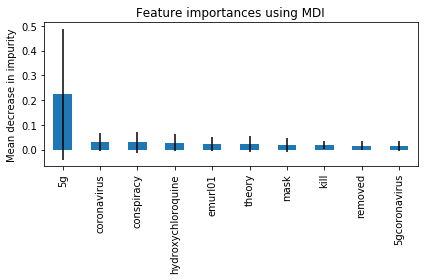

In [28]:
fig, ax = plt.subplots()
top_k_forest_importances["importances"].plot.bar(
    yerr=top_k_forest_importances["std"], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Evaluate Algorithms: Mosquito myth

### Prepare training and validation data

In [29]:
# Separate training and final validation data set. First remove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

valueArray = msq_df_is_myth.values
Y = valueArray[:,1]
Y = Y.astype('float')
test_size = 0.2
seed = 3
X_train, X_validate, Y_train, Y_validate = train_test_split(
    X_msq, 
    Y, 
    test_size=test_size, 
    random_state=seed)

print(f'Y_train Distribution: {Counter(Y_train).most_common()}')

Y_train Distribution: [(0.0, 557), (1.0, 441)]


### Oversample to desirable ratio

In [30]:
sampling_ratio = 0.5 # ratio of minority to total cases
undersample = False # whether to undersample or oversample

X_balanced, Y_balanced = resample_data(
    X_msq, #X_train, 
    Y, #Y_train, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({0.0: 685, 1.0: 563})
Y_resample: Counter({1.0: 685, 0.0: 685})


## 10-Fold Cross Validation: Mosquito myth

In [31]:

models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(n_estimators=40, random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP)', MLPClassifier(max_iter=100, activation='relu')))

# Baseline: distribution of labeled data
print(f'Distribution of labeled disinfectants tweets: {Counter(Y_balanced).most_common()}')
print()

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced,
                                   Y=Y_balanced, 
                                   df=msq_df, 
                                   text_col='text_cleaned', 
                                   vectorizer=msq_vectorizer)

Computing predictions:   0%|          | 0/1248 [00:00<?, ?it/s]

Distribution of labeled disinfectants tweets: [(1.0, 685), (0.0, 685)]

K-Nearest Neighbors (KNN):



Computing predictions: 100%|██████████| 1248/1248 [00:02<00:00, 453.66it/s]


Distribution of predicted labels:
 yes    732
no     516
Name: prediction, dtype: int64

Mean (std):	 0.6672 (0.4712)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[436 249]
 [ 20 665]]

Report:
               precision    recall  f1-score   support

         0.0       0.96      0.64      0.76       685
         1.0       0.73      0.97      0.83       685

    accuracy                           0.80      1370
   macro avg       0.84      0.80      0.80      1370
weighted avg       0.84      0.80      0.80      1370


Random Forest (RF):



Computing predictions: 100%|██████████| 1248/1248 [00:08<00:00, 153.51it/s]


Distribution of predicted labels:
 no     676
yes    572
Name: prediction, dtype: int64

Mean (std):	 0.5241 (0.4994)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[640  45]
 [ 12 673]]

Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       685
         1.0       0.94      0.98      0.96       685

    accuracy                           0.96      1370
   macro avg       0.96      0.96      0.96      1370
weighted avg       0.96      0.96      0.96      1370


Decision Tree (DT):



Computing predictions:   6%|▌         | 77/1248 [00:00<00:01, 766.29it/s]

Distribution of predicted labels:
 no     684
yes    564
Name: prediction, dtype: int64

Mean (std):	 0.519 (0.4996)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[641  44]
 [ 18 667]]

Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       685
         1.0       0.94      0.97      0.96       685

    accuracy                           0.95      1370
   macro avg       0.96      0.95      0.95      1370
weighted avg       0.96      0.95      0.95      1370


Multinomial Naive Bayes (MNB):



Computing predictions:   0%|          | 0/1248 [00:00<?, ?it/s]

Distribution of predicted labels:
 yes    639
no     609
Name: prediction, dtype: int64

Mean (std):	 0.646 (0.4782)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[480 205]
 [  5 680]]

Report:
               precision    recall  f1-score   support

         0.0       0.99      0.70      0.82       685
         1.0       0.77      0.99      0.87       685

    accuracy                           0.85      1370
   macro avg       0.88      0.85      0.84      1370
weighted avg       0.88      0.85      0.84      1370


Logistic Regression (LR):



Computing predictions: 100%|██████████| 1248/1248 [00:01<00:00, 756.28it/s]


Distribution of predicted labels:
 no     666
yes    582
Name: prediction, dtype: int64

Mean (std):	 0.5073 (0.4999)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[644  41]
 [ 31 654]]

Report:
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       685
         1.0       0.94      0.95      0.95       685

    accuracy                           0.95      1370
   macro avg       0.95      0.95      0.95      1370
weighted avg       0.95      0.95      0.95      1370


Support Vector Machine (SVM):



Computing predictions:   0%|          | 0/1248 [00:00<?, ?it/s]/home/app59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/app59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/app59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/app59/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype expli

Mean (std):	 0.4 (0.4899)
Accuracy:	 {0.0, 4}

Confusion matrix:
 [[389 296]
 [433 252]]

Report:
               precision    recall  f1-score   support

         0.0       0.47      0.57      0.52       685
         1.0       0.46      0.37      0.41       685

    accuracy                           0.47      1370
   macro avg       0.47      0.47      0.46      1370
weighted avg       0.47      0.47      0.46      1370


Multi-Layer Perceptron (MLP):



/home/app59/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
Computing predictions: 100%|██████████| 1248/1248 [00:01<00:00, 727.00it/s]

Distribution of predicted labels:
 no     683
yes    565
Name: prediction, dtype: int64

Mean (std):	 0.4905 (0.4999)
Accuracy:	 {1.0, 4}

Confusion matrix:
 [[644  41]
 [ 54 631]]

Report:
               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       685
         1.0       0.94      0.92      0.93       685

    accuracy                           0.93      1370
   macro avg       0.93      0.93      0.93      1370
weighted avg       0.93      0.93      0.93      1370




In [32]:
# Save best model - Mosquitoes

#Model file output format
best_model_suffix = "LR" # this model has best accuracy
thisday = date.today().strftime("%m%d%y")

MYTH_NAME_mod_fp = f'../models/tweet_classifier_mosquitoes_{str(best_model_suffix)}_{str(thisday)}.joblib'

best_model = LogisticRegression(random_state=seed).fit(X_balanced, Y_balanced)

joblib.dump(best_model, MYTH_NAME_mod_fp)

['../models/tweet_classifier_mosquitoes_LR_042622.joblib']

### Inspect featured keywords (Random Forest)

In [33]:
# Get feature names
# feature_names = [f"feature {i}" for i in range(X_balanced.shape[1])]
feature_names = msq_vectorizer.get_feature_names_out()
rf_model = RandomForestClassifier(n_estimators=40, random_state=seed).fit(X_balanced, Y_balanced)

# Get feature importances from the randome forest model
importances = rf_model.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

print(type(feature_names))
print(type(X_balanced))

print(X_balanced.shape)
print(feature_names.shape)

# Build dataframe
forest_importances = pd.DataFrame()
forest_importances["importances"] = importances
forest_importances["std"] = std
forest_importances.index = feature_names
forest_importances = forest_importances.sort_values(
    by=["importances", "std"], ascending=False)

# See top k important features
top_k = 10
top_k_forest_importances = forest_importances.head(top_k)
print(list(top_k_forest_importances.index))

<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
(1370, 4624)
(4624,)
['mosquito', 'transmitted', 'coronavirus', 'covid19', 'bite', 'removed', 'transmit', 'carry', 'emurl01', 'em']


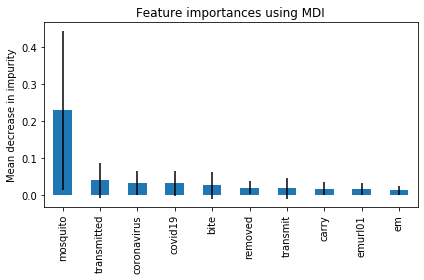

In [34]:
fig, ax = plt.subplots()
top_k_forest_importances["importances"].plot.bar(
    yerr=top_k_forest_importances["std"], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
